In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pipedream_solver import ngeometry
import scipy.optimize
from numba import njit

%matplotlib inline

# Compute closest trapezoidal geometry to HAND geometry

In [2]:
# Max depth considered
max_y = 10.

# Meters to km
m_per_km = 1000.

@njit
def trapezoidal_B(h_Ik, g2, g3, g1=max_y):
    n = len(h_Ik)
    B_ik = np.zeros(n, dtype=np.float64)
    for i in range(n):
        B_ik[i] = ngeometry.Trapezoidal_B_ik(h_Ik[i], h_Ik[i], g1, g2, g3)
    return B_ik

In [3]:
# Read dataset
df = pd.read_excel('FullCrosswalkBartos_TableToExcel.xlsx')
df = df[df['Bartos'] == 1]

# Extract unique reach ids
reach_ids = set(df['feature_id'].unique())

In [4]:
# Compute hydraulic geometry parameters for trapezoidal channel that match data
results = {}
x_data_all = {}
y_data_all = {}

for reach_id in reach_ids:
    # Select reach and join HydroIDs together
    reach = df[df['feature_id'] == reach_id]
    reach_sum = reach.groupby('Stage').sum()

    # Compute cross-sectional area, perimeter, and top width
    h = reach_sum.index.values
    A = reach_sum['Volume__m3_'] / (m_per_km * reach_sum['LENGTHKM'])
    P = reach_sum['WetArea__m2_'] / (m_per_km * reach_sum['LENGTHKM'])
    B = reach_sum['SurfaceArea__m2_'] / (m_per_km * reach_sum['LENGTHKM'])
    
    # Get x and y data for parameter fitting
    x_data = h
    y_data = B.fillna(0.).values
    stage_limit = x_data <= max_y
    x_data = x_data[stage_limit]
    y_data = y_data[stage_limit]
    
    # Compute bottom width (g2) and inverse slope (g3) 
    fit = scipy.optimize.curve_fit(trapezoidal_B, x_data, y_data, bounds=([0, 0], [np.inf, np.inf]))
    g1 = max_y
    g2, g3 = fit[0]
    
    # Write resulting parameters
    results[reach_id] = {'g1' : g1, 'g2' : g2, 'g3' : g3}
    x_data_all[reach_id] = x_data
    y_data_all[reach_id] = y_data

# Resulting geometric parameters

In [5]:
# Results
(pd.DataFrame.from_dict(results, orient='index')
.rename(columns={'g1' : 'max_depth',
                 'g2' : 'bottom_width',
                 'g3' : 'inverse_slope'}))

,max_depth,bottom_width,inverse_slope
5559104,10.0,3.026373e-19,37.529595
5559296,10.0,8.711116e-08,23.851827
5559138,10.0,1.087932e+02,63.195894
5559200,10.0,6.587944e+00,24.730628
5559076,10.0,7.971237e+01,16.890835
5559174,10.0,3.873615e+01,32.986227
5559078,10.0,1.140738e+01,18.647142
5559146,10.0,1.226025e+01,38.745611
5559116,10.0,2.475089e+01,31.760868
5559148,10.0,2.671199e-21,38.022282


# Compare trapezoidal and HAND top width

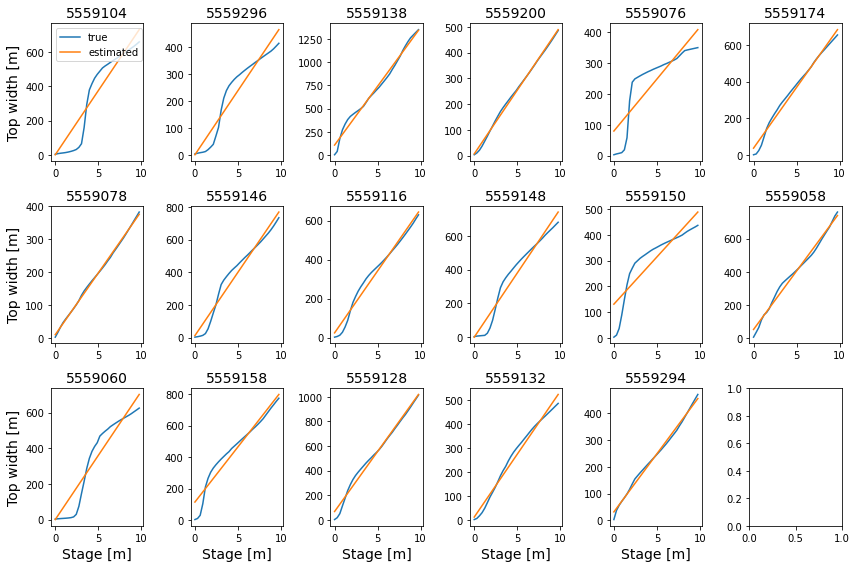

In [6]:
fig, ax = plt.subplots(3, 6, figsize=(12, 8))

for index, reach_id in enumerate(results):
    ax.flat[index].plot(x_data_all[reach_id], y_data_all[reach_id], label='true')
    ax.flat[index].plot(x_data_all[reach_id], trapezoidal_B(x_data_all[reach_id],
                                                 results[reach_id]['g2'],
                                                 results[reach_id]['g3']), label='estimated')
    ax.flat[index].set_title(reach_id, size=14)
    if (index % ax.shape[1]) == 0:
        ax.flat[index].set_ylabel('Top width [m]', size=14)
    if (index >= ax.shape[1] * (ax.shape[0] - 1)):
        ax.flat[index].set_xlabel('Stage [m]', size=14)

ax.flat[0].legend(loc=2)
plt.tight_layout()